In [210]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
import torch
import numpy as np
from os import environ
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.wcs import WCS
from bliss.surveys.sdss import SloanDigitalSkySurvey
import pandas as pd

from bliss.surveys.sdss import PhotoFullCatalog, SloanDigitalSkySurvey
from bliss.catalog import FullCatalog
from bliss.predict import prepare_image
from bliss.metrics import BlissMetrics, MetricsMode
from bliss.catalog import TileCatalog

from hydra import initialize, compose
from hydra.utils import instantiate
import copy

In [212]:
environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with initialize(config_path=".", version_base=None):
    cfg = compose("config")

## Getting data

In [51]:
sim = instantiate(cfg.simulator)

/home/sawanpa/bliss/.venv/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [52]:
tc = sim.catalog_prior.sample()
image_ids, image_id_indices = sim.randomized_image_ids(sim.catalog_prior.batch_size)
images, background, deconv, psf_params = sim.simulate_image(
    tc, image_ids, image_id_indices
)

In [6]:
tile_cat = tc.to_dict()

In [53]:
fc = tc.to_full_params()

### Input transform bar plot

In [54]:
model_names = ["log_transform_conv_3d_1e-5_v2", "vectorized_rolling_z", "realigned_log_conv_3d_CLAHE_1e-5", "zscore_conv3d"]
flags = [["log_transform"], ["rolling_z_score"], ["log_transform", "clahe"], ["z_score"]]
model_preds = {}
model_shorthand = ["log_conv_3d", "10x10_rolling_z", "log_clahe_conv_3d", "80x80_z"]
for i in range(len(model_shorthand)):
    model_preds[model_shorthand[i]] = {"metrics": {}, "flags": flags[i], "filename": model_names[i], "est_cat": None}


In [33]:
cfg.encoder.input_transform_params

{'use_deconv_channel': False, 'concat_psf_params': False, 'log_transform': False, 'rolling_z_score': True, 'z_score': False, 'clahe': False}

In [55]:
def pred(model_preds, cfg, data_dir, tile_cat, images, background):
    conf = cfg.copy()
    for _, settings in model_preds.items():
        imgs = copy.deepcopy(images)
        bgs = copy.deepcopy(background)
        tc = copy.deepcopy(tile_cat)
        tfs = conf.encoder.input_transform_params
        for tf in tfs.keys():
            tfs[tf] = (tf in settings['flags'])
        conf.predict.weight_save_path = data_dir + f"{settings['filename']}.pt"
        encoder = instantiate(conf.encoder)
        enc_state_dict = torch.load(conf.predict.weight_save_path)
        encoder.load_state_dict(enc_state_dict)
        encoder.eval()
        batch = {"images": imgs, "background": bgs}
        true_tile_cat = tc.symmetric_crop(encoder.tiles_to_crop)
        pred = encoder.encode_batch(batch)
        est_tile_cat = encoder.variational_mode(pred, return_full=False)
        metrics = encoder.metrics(true_tile_cat, est_tile_cat)
        settings['metrics'] = metrics
        settings['est_cat'] = est_tile_cat
    return model_preds

In [56]:
data_dir = "/data/scratch/sawanpa/paper_models/"
imgs = copy.deepcopy(images)
bgs = copy.deepcopy(background)
tile_cat = copy.deepcopy(tc)
p = pred(model_preds, cfg, data_dir, tile_cat, imgs, bgs)

In [48]:
p.keys()

dict_keys(['log_conv_3d', '10x10_rolling_z', 'log_clahe_conv_3d', '80x80_z'])

In [62]:
p['80x80_z']['metrics']['f1']

0.7349926829338074

In [44]:
list(p['80x80_z']['est_cat'].keys())

['star_fluxes', 'source_type', 'galaxy_params', 'galaxy_fluxes']

In [97]:
fluxes = p['log_conv_3d']['est_cat']['star_fluxes'][0, :, :, 0, 2] + p['log_conv_3d']['est_cat']['galaxy_fluxes'][0, :, :, 0, 2]

In [72]:
mask = tc.n_sources[0, 1:-1, 1:-1]

In [95]:
true_fluxes = mask*tc['star_fluxes'][0, 1:-1, 1:-1, 0, 2] + mask*tc['galaxy_fluxes'][0, 1:-1, 1:-1, 0, 2]

In [87]:
fluxes.shape

torch.Size([18, 18])

In [98]:
((true_fluxes - fluxes) / true_fluxes).nanmean()

tensor(0.48109, dtype=torch.float64, grad_fn=<DivBackward0>)

In [59]:
fluxes.max()

tensor(57716.96875, grad_fn=<MaxBackward1>)

In [194]:
transform_fig = ['Log', 'Log + CLAHE', '80x80 Window Z-Score', '10x10 Rolling Z-Score']

In [195]:
m = {'Model': transform_fig, 'Val/Loss': np.array([0.8962, 0.8247, 0.7612, 0.773], dtype=float), 'Test/Loss': np.array([0.8997, 0.8399, 0.7663, 0.8073], dtype=float), 'Test/Avg_Distance': np.array([1.053, 1.037, 0.7991, 0.8778], dtype=float), 'Test/(1 - F1)': 1 - np.array([0.8098, 0.8169, 0.8438, 0.8249], dtype=float), 'Flux Residual Error': np.array([0.48109, 0.29274, 0.54760, 0.33670])}
# m = torch.load('data/scratch/sawanpa/paper_models/input_transform_metrics.pt')
# m = {'Test/Loss': np.array([0.8997, 0.8399, 0.7663, 0.8073], dtype=float), 'Val/Loss': np.array([0.8962, 0.8247, 0.7612, 0.773], dtype=float), 'Test/F1': np.array([0.8098, 0.8169, 0.8438, 0.8249], dtype=float), 'Test/Avg_Distance': np.array([1.053, 1.037, 0.7991, 0.8778], dtype=float)}

In [68]:
transform_fig

{'log_transform': {'Test/Loss': 0.8997,
  'Val/Loss': 0.8962,
  'Test/F1': 0.8098,
  'Test/Avg_Distance': 1.053},
 'log_clahe': {'Test/Loss': 0.8399,
  'Val/Loss': 0.8247,
  'Test/F1': 0.8169,
  'Test/Avg_Distance': 1.037},
 '80x80_zscore': {'Test/Loss': 0.7663,
  'Val/Loss': 0.7612,
  'Test/F1': 0.8438,
  'Test/Avg_Distance': 0.7991},
 '10x10_rolling_z_score': {'Test/Loss': 0.8073,
  'Val/Loss': 0.773,
  'Test/F1': 0.8249,
  'Test/Avg_Distance': 0.8778}}

In [196]:
df = pd.DataFrame(data=m, columns=m.keys())

In [197]:
df.set_index("Model")

,Val/Loss,Test/Loss,Test/Avg_Distance,Test/(1 - F1),Flux Residual Error
Model,,,,,
Log,0.8962,0.8997,1.0530,0.1902,0.48109
Log + CLAHE,0.8247,0.8399,1.0370,0.1831,0.29274
80x80 Window Z-Score,0.7612,0.7663,0.7991,0.1562,0.54760
10x10 Rolling Z-Score,0.7730,0.8073,0.8778,0.1751,0.33670


In [198]:
z = df[['Model', 'Val/Loss', 'Test/Loss']]

In [199]:
z = z.melt('Model', var_name='Metrics', value_name='Loss')

In [104]:
z

,Model,Metrics,Loss
0,Log,Val/Loss,0.8962
1,Log + CLAHE,Val/Loss,0.8247
2,80x80 Window Z-Score,Val/Loss,0.7612
3,10x10 Rolling Z-Score,Val/Loss,0.7730
4,Log,Test/Loss,0.8997
5,Log + CLAHE,Test/Loss,0.8399
6,80x80 Window Z-Score,Test/Loss,0.7663
7,10x10 Rolling Z-Score,Test/Loss,0.8073


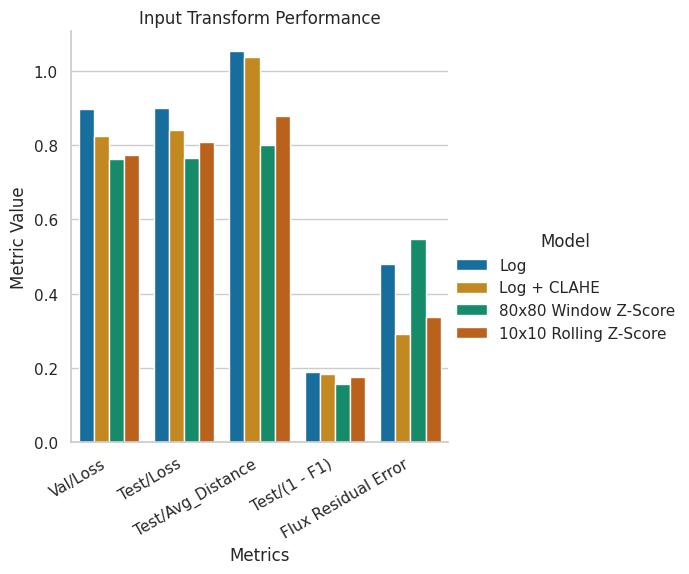

In [169]:
z = df.melt('Model', var_name='Metrics', value_name='Metric Value')
g = sns.catplot(x='Metrics', y='Metric Value', hue='Model', data=z, kind='bar')
g.set_xticklabels(rotation=30, ha='right')
g.set(title='Input Transform Performance')

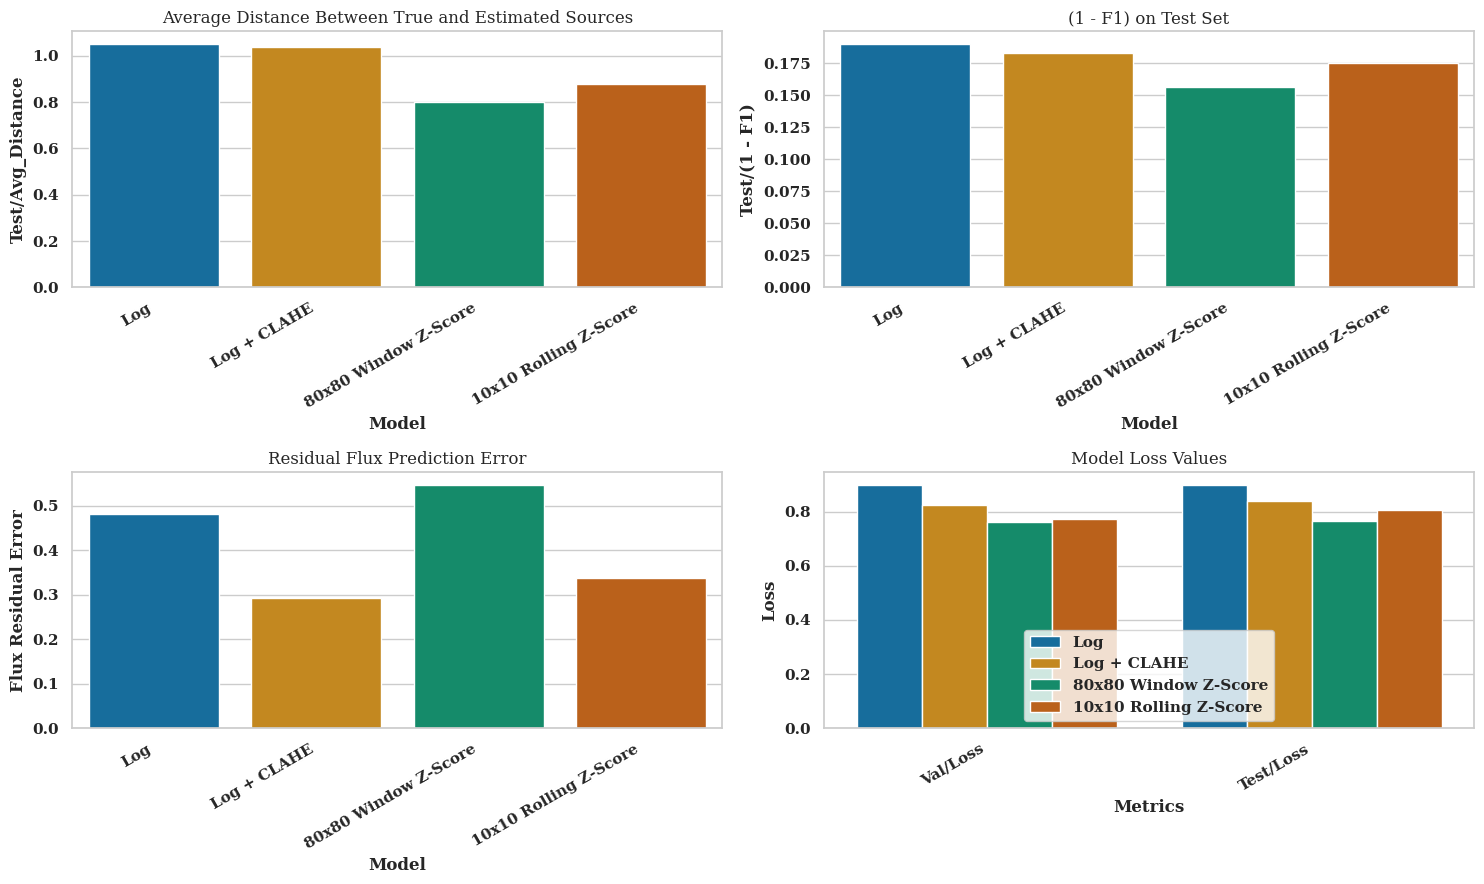

In [202]:
# fig, axes = plt.subplots(2, 2, figsize=(18, 10))
sns.set_theme(style='whitegrid', palette='colorblind', font='serif')
fig = plt.figure(figsize=(15, 9))

ax1 = fig.add_subplot(221)
a = sns.barplot(ax=ax1, x='Model', y='Test/Avg_Distance', data=df)
ax1.set_xticklabels(rotation=30, ha='right', labels=transform_fig)
a.set(title='Average Distance Between True and Estimated Sources')
# plt.close()

ax2 = fig.add_subplot(222)
b = sns.barplot(ax=ax2, x='Model', y='Test/(1 - F1)', data=df)
ax2.set_xticklabels(rotation=30, ha='right', labels=transform_fig)
b.set(title='(1 - F1) on Test Set')
# plt.close()

ax3 = fig.add_subplot(223)
c = sns.barplot(ax=ax3, x='Model', y='Flux Residual Error', data=df)
ax3.set_xticklabels(rotation=30, ha='right', labels=transform_fig)
c.set(title='Residual Flux Prediction Error')
# plt.close()

ax4 = fig.add_subplot(224)
d = sns.barplot(ax=ax4, x='Metrics', y='Loss', data=z, hue='Model')
ax4.set_xticklabels(rotation=30, ha='right', labels=["Val/Loss", "Test/Loss"])
d.set(title='Model Loss Values')
plt.legend(loc='lower center')
# plt.close()

plt.tight_layout()
plt.savefig('input_transform_bar_plot.pdf', format='pdf')

## Light source flux ratios

In [36]:
import pickle as pkl

In [37]:
with open("star_fluxes_multi_field.pkl", 'rb') as f:
    star_fluxes = pkl.load(f)

In [38]:
star_ratios = star_fluxes / star_fluxes[:, 2:3]

In [224]:
star_ratios.min()

1.2361037e-08

In [39]:
log_star_ratios = np.log(star_ratios)

In [257]:
log_star_ratios.shape

(56632, 5)

In [42]:
star_fluxes = pd.DataFrame(data=log_star_ratios)

In [45]:
star_fluxes.columns = ['U/R', 'G/R', 'R/R', 'I/R', 'Z/R']

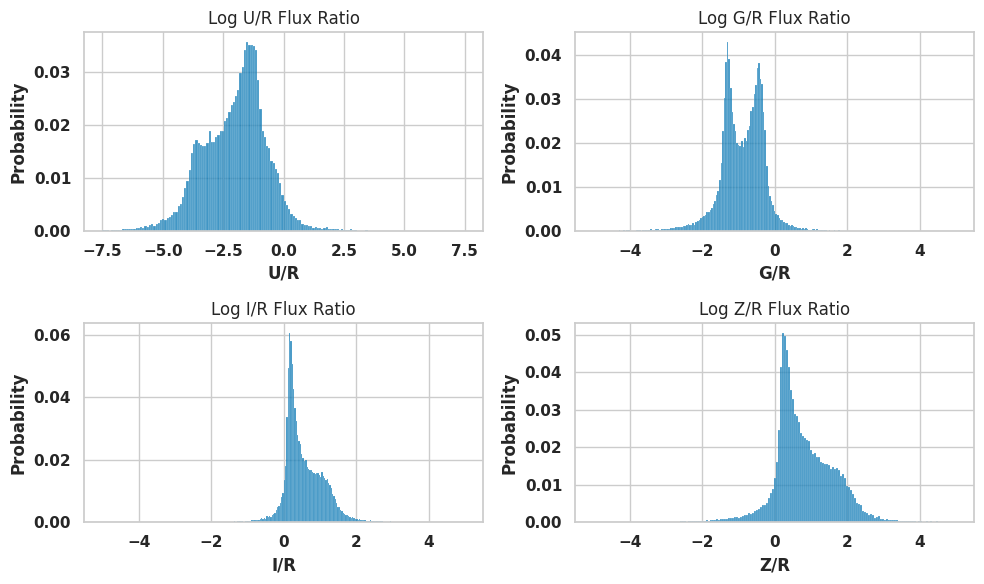

In [47]:
sns.set_theme(style='whitegrid', palette='colorblind')
Fig = plt.figure(figsize=(10, 6))

ax1 = Fig.add_subplot(221)
a = sns.histplot(ax=ax1, x='U/R', data=star_fluxes, binrange=(-7.5, 7.5), stat='probability')
a.set(title='Log U/R Flux Ratio')

ax2 = Fig.add_subplot(222)
b = sns.histplot(ax=ax2, x='G/R', data=star_fluxes, binrange=(-5, 5), stat='probability')
b.set(title='Log G/R Flux Ratio')

ax3 = Fig.add_subplot(223)
c = sns.histplot(ax=ax3, x='I/R', data=star_fluxes, binrange=(-5, 5), stat='probability')
c.set(title='Log I/R Flux Ratio')

ax4 = Fig.add_subplot(224)
d = sns.histplot(ax=ax4, x='Z/R', data=star_fluxes, binrange=(-5, 5), stat='probability')
d.set(title='Log Z/R Flux Ratio')

plt.tight_layout()
plt.savefig('source_flux_ratio_hist.pdf', format='pdf')

## Unaligned/Realigned Images

In [175]:
sim = instantiate(cfg.simulator)
tc = sim.catalog_prior.sample()
image_ids, image_id_indices = sim.randomized_image_ids(sim.catalog_prior.batch_size)

In [176]:
images, psfs, psf_params, wcs_undo = sim.image_decoder.render_images(tc, image_ids)
fc = tc.to_full_params()

In [177]:
img_copy = copy.deepcopy(images)
from bliss.predict import align

for i in range(img_copy.shape[0]):
    img_copy[i] = torch.from_numpy(
        align(
            img_copy[i].numpy(),
            wcs_undo[i],
            sim.catalog_prior.b_band,
        )
    )

In [189]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 50}

matplotlib.rc('font', **font)

In [30]:
images.shape

torch.Size([64, 5, 80, 80])

/tmp/ipykernel_1007958/4226525764.py:11: RuntimeWarning: divide by zero encountered in log
  axs[1, i-1].imshow(np.log(img_copy[ind, i]), extent=[0, 80, 80, 0], cmap=cmap)


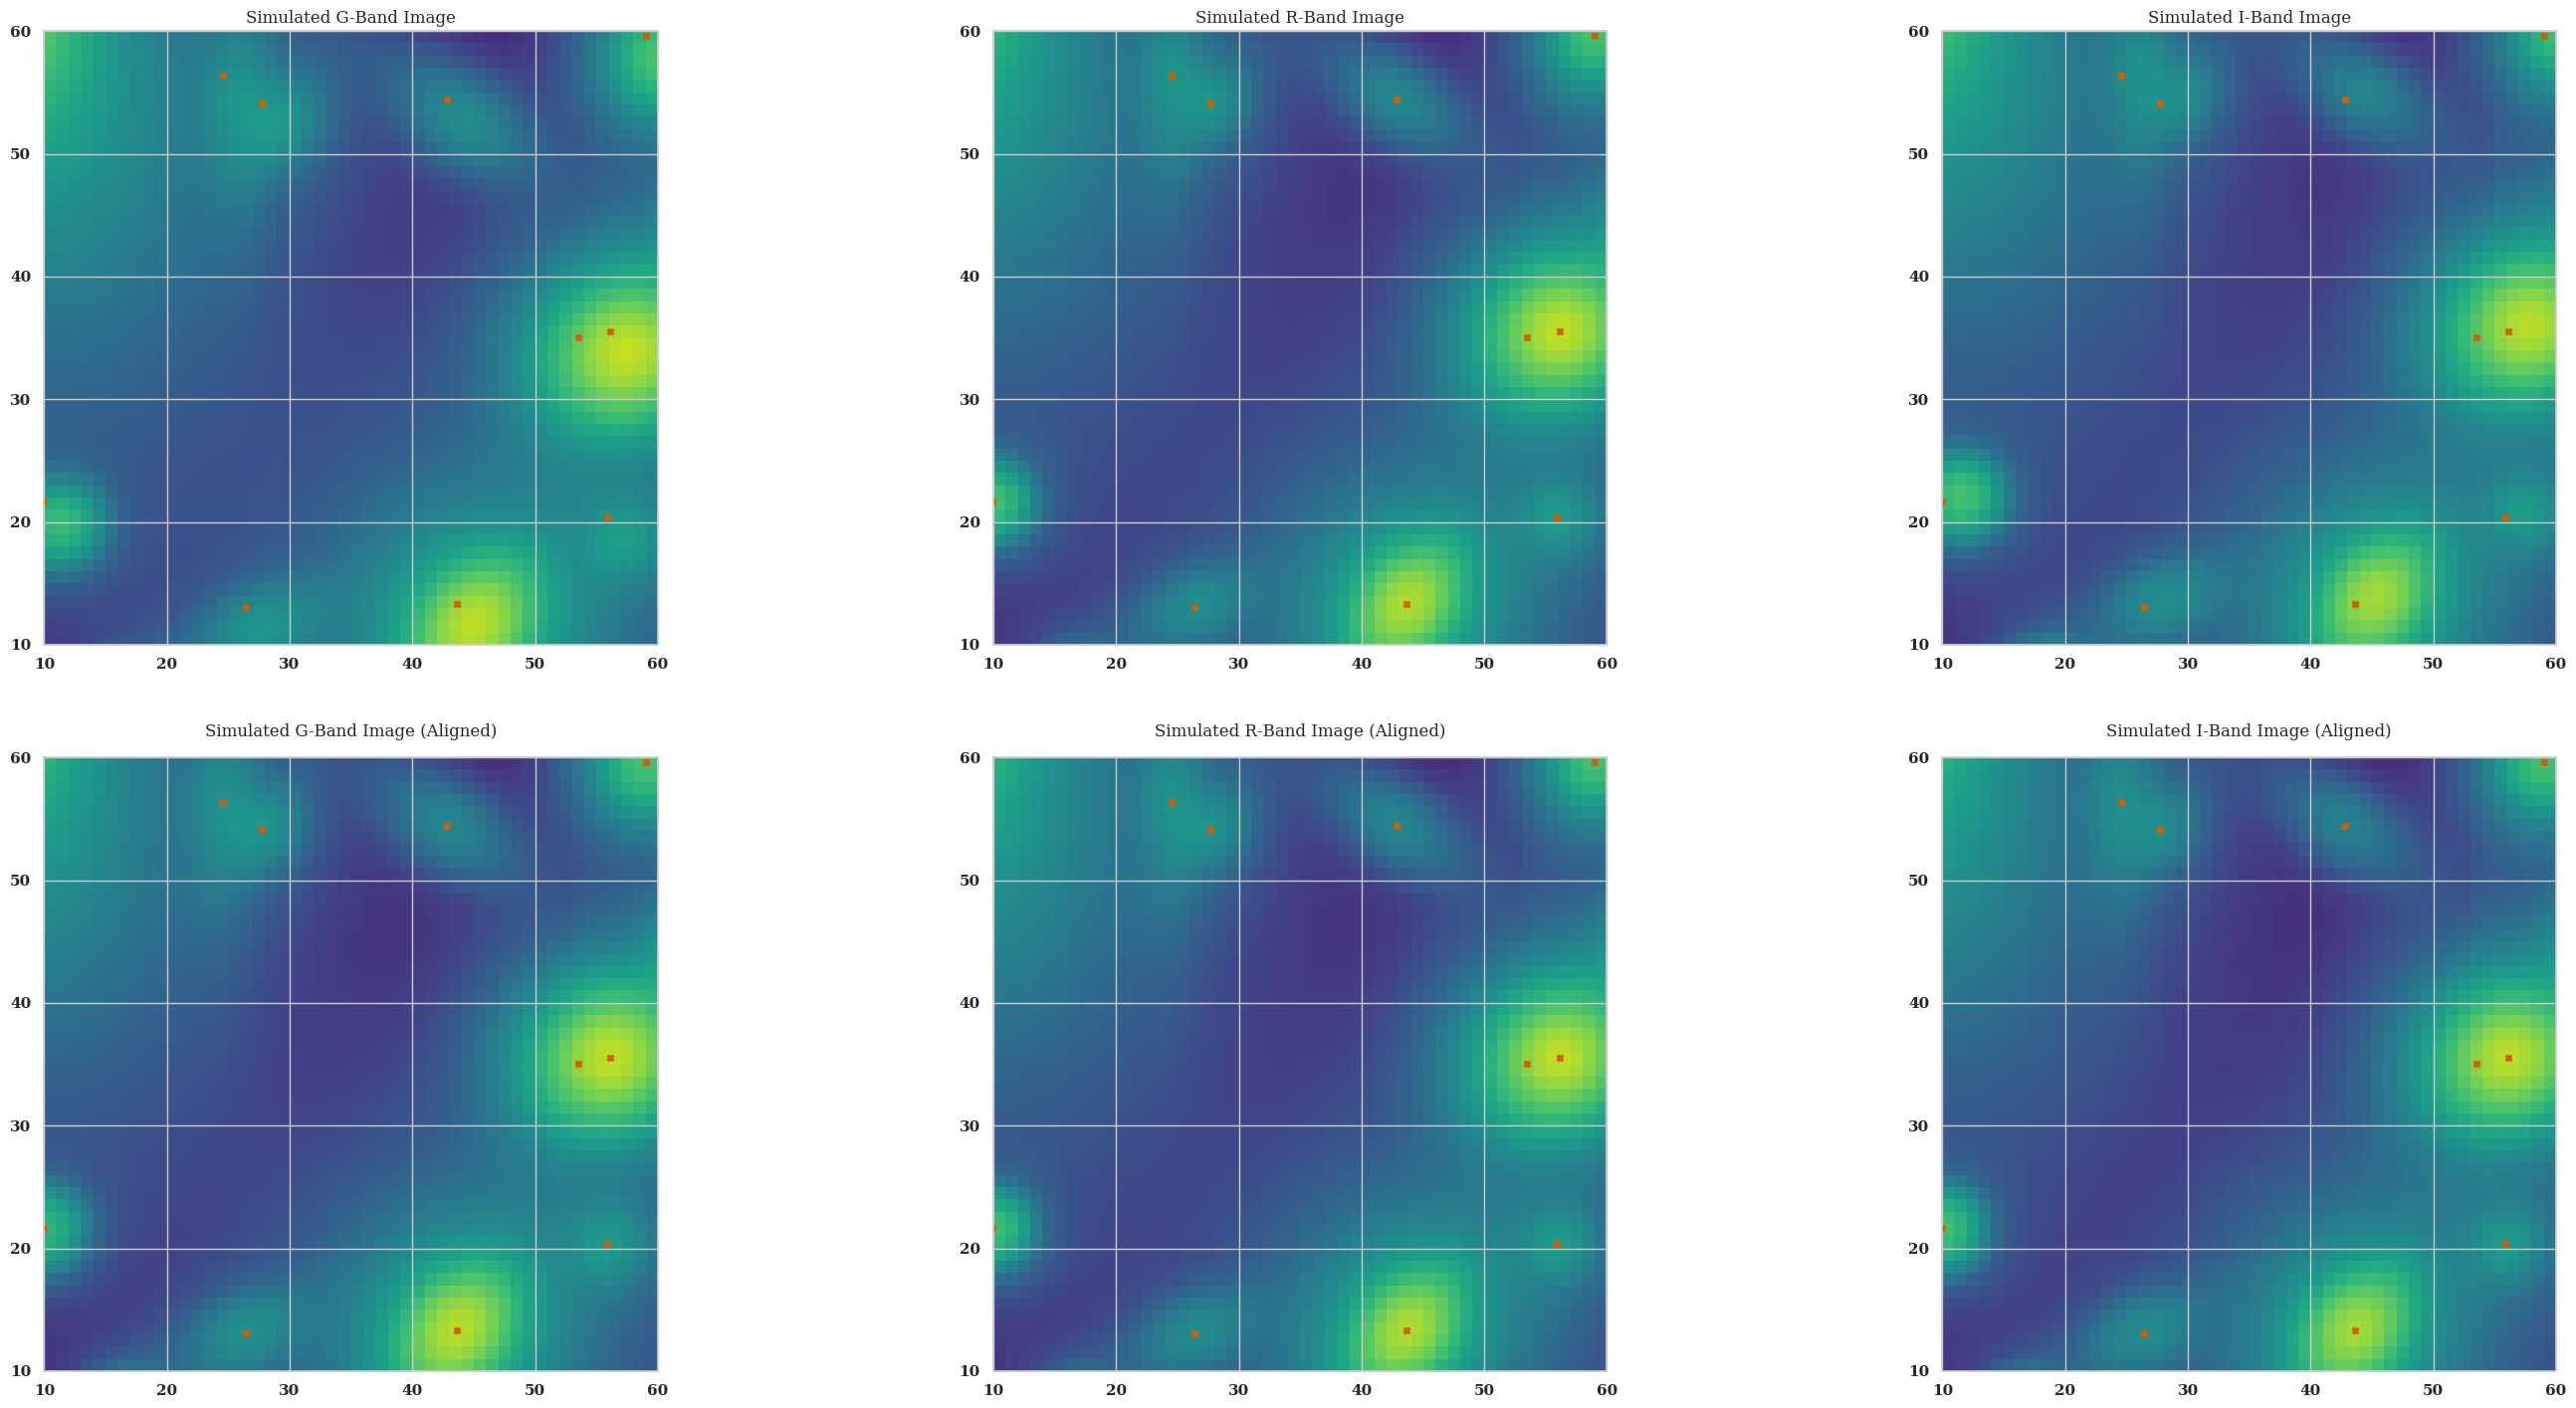

In [192]:
plt.rcParams.update({'font.size': 35})
cmap = 'viridis'
ind = 4
c = 'r'
d = {0: 'U', 1: 'G', 2: 'R', 3: 'I', 4: 'Z'}
fig, axs = plt.subplots(2, 3, figsize=(35, 15))
for i in range(1, 4):
    axs[0, i-1].imshow(np.log(images[ind, i]), extent=[0, 80, 80, 0], cmap=cmap)
    axs[0, i-1].scatter(fc['plocs'][ind, :, 1], fc['plocs'][ind, :, 0], s=20, c=c, marker='X')
    axs[0, i-1].set_title(f'Simulated {d[i]}-Band Image')
    axs[1, i-1].imshow(np.log(img_copy[ind, i]), extent=[0, 80, 80, 0], cmap=cmap)
    axs[1, i-1].scatter(fc['plocs'][ind, :, 1], fc['plocs'][ind, :, 0], s=20, c=c, marker='X')
    axs[1, i-1].set_title(f'Simulated {d[i]}-Band Image (Aligned)', pad=15.0)
    axs[0, i-1].set_xlim(10, 60)
    axs[1, i-1].set_xlim(10, 60)
    axs[0, i-1].set_ylim(10, 60)
    axs[1, i-1].set_ylim(10, 60)
fig.tight_layout()
plt.tight_layout()
# plt.show()
plt.savefig("unaligned_realigned_imgs.pdf", format="pdf")

### Ablation detection figure

In [8]:
def pred(cfg, tile_cat, images, background):
    conf = cfg.copy()
    imgs = copy.deepcopy(images)
    bgs = copy.deepcopy(background)
    tc = copy.deepcopy(tile_cat)
    encoder = instantiate(conf.encoder)
    enc_state_dict = torch.load(conf.predict.weight_save_path)
    encoder.load_state_dict(enc_state_dict)
    encoder.eval()
    batch = {"images": imgs, "background": bgs}
    true_tile_cat = tc.symmetric_crop(encoder.tiles_to_crop)
    pred = encoder.encode_batch(batch)
    est_tile_cat = encoder.variational_mode(pred, return_full=False)
    return est_tile_cat

In [7]:
def create_df(key, d, max_r):
    metrics = {}
    for metric in d[key]['metrics']:
        for m in metric:
            if m not in metrics.keys():
                metrics[m] = []
            metrics[m].append(metric[m])
    for i in range(len(d[key]['tgs'])):
        if 'tgs' not in metrics.keys():
            metrics['tgs'] = []
        metrics['tgs'].append(d[key]['tgs'][i].numpy())    
    for i in range(len(d[key]['tss'])):
        if 'tss' not in metrics.keys():
            metrics['tss'] = []
        metrics['tss'].append(d[key]['tss'][i].numpy())    
    for i in range(len(d[key]['egs'])):
        if 'egs' not in metrics.keys():
            metrics['egs'] = []
        metrics['egs'].append(d[key]['egs'][i].numpy())   
    for i in range(len(d[key]['ess'])):
        if 'ess' not in metrics.keys():
            metrics['ess'] = []
        metrics['ess'].append(d[key]['ess'][i].numpy())     
    df = pd.DataFrame(metrics)
    df['Max R-Flux (Log-10)'] = max_r
    df = df.rename(columns={"detection_precision": "Precision", "detection_recall": "Recall", "f1": "F-1"})
    return df

In [239]:
sim = instantiate(cfg.simulator)
tc = sim.catalog_prior.sample()
image_ids, image_id_indices = sim.randomized_image_ids(sim.catalog_prior.batch_size)
images, background, deconv, psf_params = sim.simulate_image(
    tc, image_ids, image_id_indices
)

In [240]:
true_tile_cat = tc.symmetric_crop(cfg.encoder.tiles_to_crop)

In [242]:
d = {"vectorized_rolling_z_r.pt": {"bands": [2], "est_tile_cat": None}, "vectorized_rolling_z_gri.pt": {"bands": [1, 2, 3], "est_tile_cat": None}, "vectorized_rolling_z.pt": {"bands": [0, 1, 2, 3, 4], "est_tile_cat": None}}
for model in d.keys():
    cfg.encoder.bands = d[model]["bands"]
    cfg.predict.weight_save_path = "/data/scratch/sawanpa/paper_models/" + model
    d[model]["est_tile_cat"] = pred(cfg, tc, images, background)

In [243]:
fc = true_tile_cat.to_full_params()

In [244]:
steps = np.logspace(2.75, 6, num=12)  # fluxes

In [81]:
steps_mags = np.linspace(8, 16, num=12)  # Mags

In [245]:
metrics = BlissMetrics(survey_bands = [0, 1, 2, 3, 4], mode=MetricsMode.FULL)

In [246]:
for model in d.keys():
    fc_cat_est = d[model]['est_tile_cat'].to_full_params()
    fc_cat_true = true_tile_cat.to_full_params()
    # fc_cat_true['mags'] = 22.5 - 2.5*torch.log10(fc_cat_true['star_fluxes'][:, :, 2:3]*fc_cat_true.star_bools + fc_cat_true['galaxy_fluxes'][:, :, 2:3]*fc_cat_true.galaxy_bools)
    # fc_cat_est['mags'] = 22.5 - 2.5*torch.log10(fc_cat_est['star_fluxes'][:, :, 2:3]*fc_cat_est.star_bools + fc_cat_est['galaxy_fluxes'][:, :, 2:3]*fc_cat_est.galaxy_bools)
    fc_cat_true['mags'] = fc_cat_true['star_fluxes'][:, :, 2:3]*fc_cat_true.star_bools + fc_cat_true['galaxy_fluxes'][:, :, 2:3]*fc_cat_true.galaxy_bools
    fc_cat_est['mags'] = fc_cat_est['star_fluxes'][:, :, 2:3]*fc_cat_est.star_bools + fc_cat_est['galaxy_fluxes'][:, :, 2:3]*fc_cat_est.galaxy_bools
    d[model]["metrics"] = []
    d[model]['tgs'] = []
    d[model]['tss'] = []
    d[model]['egs'] = []
    d[model]['ess'] = []
    for j in range(len(steps[3:-1])):
        fc_cat_est_mod = fc_cat_est.apply_param_bin("mags", steps[j], steps[j+1])
        fc_cat_true_mod = fc_cat_true.apply_param_bin("mags", steps[j], steps[j+1])
        d[model]['metrics'].append(metrics(fc_cat_true_mod, fc_cat_est_mod))
        d[model]['tgs'].append(fc_cat_true_mod.galaxy_bools.sum())
        d[model]['tss'].append(fc_cat_true_mod.star_bools.sum())
        d[model]['egs'].append(fc_cat_est_mod.galaxy_bools.sum())
        d[model]['ess'].append(fc_cat_est_mod.star_bools.sum())

In [247]:
whole_df = create_df("vectorized_rolling_z.pt", d, np.log10(steps[4:]))
gri_df = create_df("vectorized_rolling_z_gri.pt", d, np.log10(steps[4:]))
r_df = create_df("vectorized_rolling_z_r.pt", d, np.log10(steps[4:]))

In [250]:
r_df[['Model']] = "R"

In [251]:
total = pd.concat([whole_df, gri_df, r_df])

In [ ]:
fluxes = fc_cat_true_mod['star_fluxes']*fc_cat_true_mod.star_bools + fc_cat_true_mod['galaxy_fluxes']*fc_cat_true_mod.galaxy_bools
est_sources = fc_
n_boots = 1000
n_matches = len(fluxes)
n_bins = len(steps[4:])
boot_precision = np.zeros((n_boots, n_bins))
boot_recall = np.zeros((n_boots, n_bins))

boot_indices = np.random.randint(0, n_matches, (n_boots, n_matches))

# compute boostrap precision and recall per bin
for ii in range(n_boots):
    bins_ii = fluxes[boot_indices[ii]]
    tgbools_ii = tgbools[boot_indices[ii]]
    egbools_ii = egbools[boot_indices[ii]]
    for jj, (b1, b2) in enumerate(bins):
        keep = (b1 < bins_ii) & (bins_ii < b2)
        tgbool_ii = tgbools_ii[keep]
        egbool_ii = egbools_ii[keep]

        p, r = compute_detection_pr()
        boot_precision[ii][jj] = p
        boot_recall[ii][jj] = r

In [ ]:
def compute_detection_pr(est, true):
    pass

[Text(0.5, 1.0, 'Recall for Multi-Band Inference')]

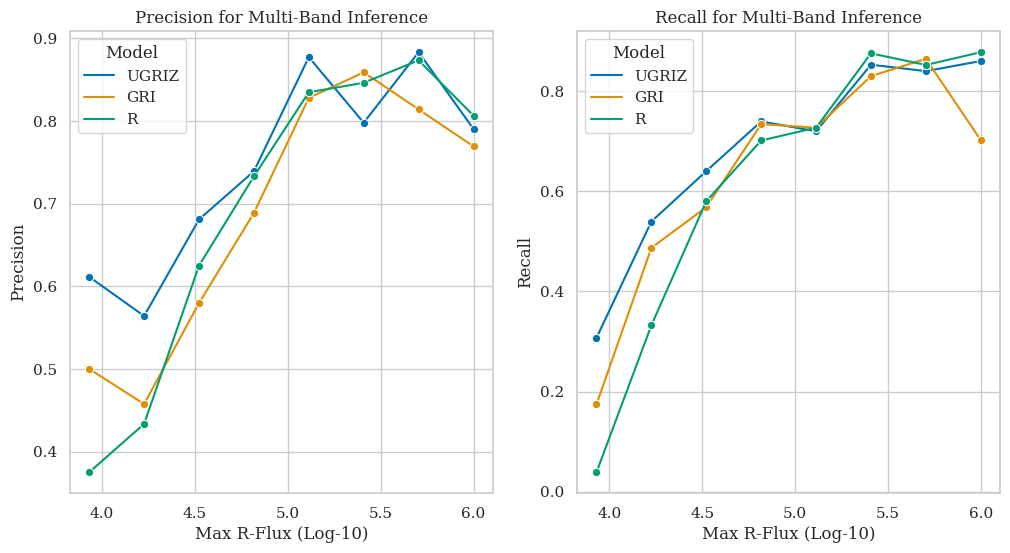

In [252]:
sns.set_theme(style='whitegrid', palette='colorblind', font='serif')
Fig = plt.figure(figsize=(12, 6))

ax1 = Fig.add_subplot(121)
a = sns.lineplot(data=total, x='Max R-Flux (Log-10)', y='Precision', hue='Model', marker='o', dashes=True)
a.set(title='Precision for Multi-Band Inference')

ax2 = Fig.add_subplot(122)
b = sns.lineplot(data=total, x='Max R-Flux (Log-10)', y='Recall', hue='Model', marker='o', dashes=True)
b.set(title='Recall for Multi-Band Inference')
# plt.savefig('Ablation_PR_fig.pdf', format='pdf')

## Mendoza et al. (2023) Detection/Classification Figures

In [341]:
from typing import Dict, List, Tuple

In [342]:
whole_df_dict = {'precision': np.array(whole_df['Precision']), 'recall': np.array(whole_df['Recall']), 'tgcount': np.array(whole_df['tgs']), 'tscount': np.array(whole_df['tss']), 'egcount': np.array(whole_df['egs']), 'escount': np.array(whole_df['ess'])}

In [345]:
def _make_pr_figure(
    bins: np.ndarray,
    data: Dict[str, np.ndarray],
    xlabel: str,
    xlims: Tuple[float, float] = None,
    ylims: Tuple[float, float] = None,
    ylims2: Tuple[float, float] = None,
    ratio: float = 2,
    where_step: str = "mid",
    n_ticks: int = 5,
    ordmag: int = 3,
    metric_type: str = "Detection",
    legend_size_hist: int = 10,
):
    precision = data["precision"]
    recall = data["recall"]
    boot_precision = data["boot"]["precision"]
    boot_recall = data["boot"]["recall"]
    tgcount = data["tgcount"]
    tscount = data["tscount"]
    egcount = data["egcount"]
    escount = data["escount"]

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, ratio]}, sharex=True
    )

    # (bottom) plot of precision and recall
    ymin = min(precision.min(), recall.min())
    yticks = np.arange(np.round(ymin, 1), 1.1, 0.1)
    c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][0]
    precision1 = np.quantile(boot_precision, 0.25, 0)
    precision2 = np.quantile(boot_precision, 0.75, 0)
    ax2.plot(bins, precision, "-o", color=c1, label=r"Precision", markersize=6)
    ax2.fill_between(bins, precision1, precision2, color=c1, alpha=0.5)

    c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][1]
    recall1 = np.quantile(boot_recall, 0.25, 0)
    recall2 = np.quantile(boot_recall, 0.75, 0)
    ax2.plot(bins, recall, "-o", color=c2, label=r"Recall", markersize=6)
    ax2.fill_between(bins, recall1, recall2, color=c2, alpha=0.5)

    ax2.legend()
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(rf"{metric_type} Metric")
    ax2.set_yticks(yticks)
    ax2.grid(linestyle="-", linewidth=0.5, which="major", axis="both")

    if xlims is not None:
        ax2.set_xlim(xlims)
    if ylims is not None:
        ax2.set_ylim(ylims)
    if ylims2 is not None:
        ax1.set_ylim(ylims2)

    # setup histogram plot up top
    c1 = plt.rcParams["axes.prop_cycle"].by_key()["color"][3]
    c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][4]
    ax1.step(bins, tgcount, label="True galaxies", where=where_step, color=c1)
    ax1.step(bins, tscount, label="True stars", where=where_step, color=c2)
    ax1.step(bins, egcount, label="Pred. galaxies", ls="--", where=where_step, color=c1)
    ax1.step(bins, escount, label="Pred. stars", ls="--", where=where_step, color=c2)
    ymax = max(tgcount.max(), tscount.max(), egcount.max(), escount.max())
    yticks = np.round(np.linspace(0, ymax, n_ticks), -ordmag)
    ax1.set_yticks(yticks)
    ax1.set_ylabel(r"Counts")
    ax1.legend(loc="best", prop={"size": legend_size_hist})
    ax1.grid(linestyle="-", linewidth=0.5, which="major", axis="both")
    plt.subplots_adjust(hspace=0)
    return fig

In [167]:
np.log10(steps)

array([       2.75,      3.0455,      3.3409,      3.6364,      3.9318,      4.2273,      4.5227,      4.8182,      5.1136,      5.4091,      5.7045,           6])

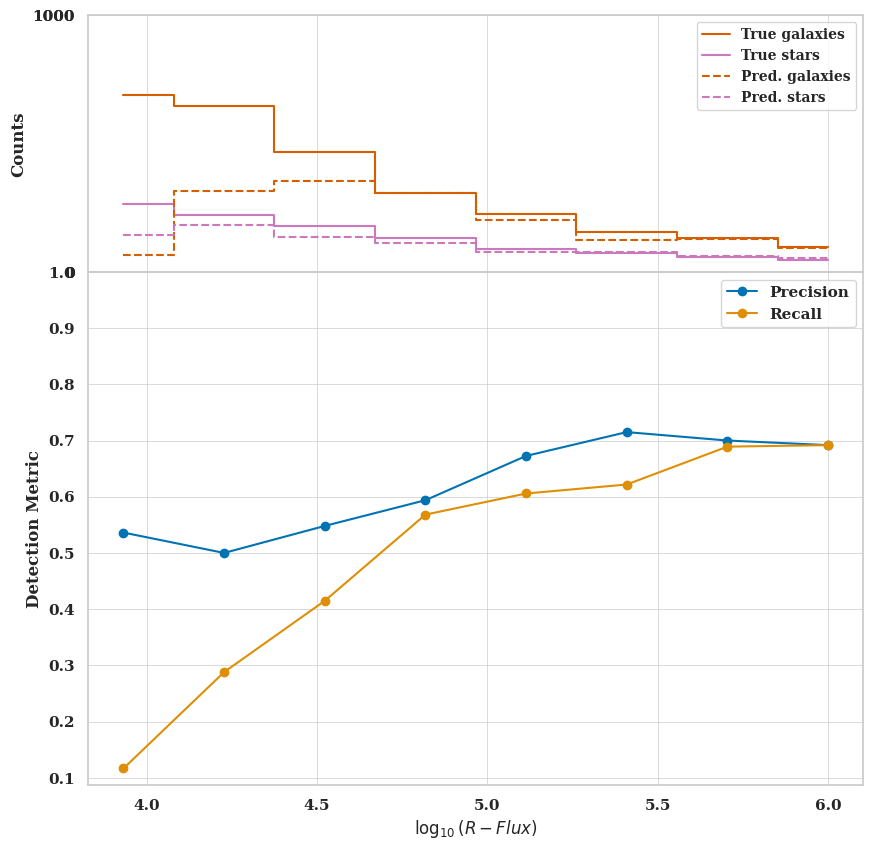

In [344]:
fig = _make_pr_figure(np.log10(steps[4:]), whole_df_dict, r"$\log_{10} (R-Flux)$")
# plt.savefig('Ismael_PR_fig_rep.pdf', format='pdf')

In [204]:
from matplotlib.figure import Figure

In [352]:
def _compute_pr(tgbool: np.ndarray, egbool: np.ndarray):
    t = np.sum(tgbool)
    p = np.sum(egbool)

    cond1 = np.equal(tgbool, egbool).astype(bool)
    cond2 = tgbool.astype(bool)
    tp = (cond1 & cond2).astype(float).sum()

    assert np.all(np.greater_equal(t, tp))
    assert np.all(np.greater_equal(p, tp))
    if t == 0 or p == 0:
        return np.nan, np.nan

    return tp / p, tp / t

def create_figure(data) -> Figure:
    snrs, tgbools, egbools = data["classification"].values()
    snr_bins = data["detection"]["bins"]
    n_matches = len(snrs)
    n_bins = len(snr_bins)
    n_boots = 1000

    precision = np.zeros(n_bins)
    recall = np.zeros(n_bins)
    tgals = np.zeros(n_bins)
    egals = np.zeros(n_bins)
    tstars = np.zeros(n_bins)
    estars = np.zeros(n_bins)

    boot_precision = np.zeros((n_boots, n_bins))
    boot_recall = np.zeros((n_boots, n_bins))

    boot_indices = np.random.randint(0, n_matches, (n_boots, n_matches))

    # compute boostrap precision and recall per bin
    for ii in range(n_boots):
        snrs_ii = snrs[boot_indices[ii]]
        tgbools_ii = tgbools[boot_indices[ii]]
        egbools_ii = egbools[boot_indices[ii]]
        for jj, (b1, b2) in enumerate(snr_bins):
            keep = (b1 < snrs_ii) & (snrs_ii < b2)
            tgbool_ii = tgbools_ii[keep]
            egbool_ii = egbools_ii[keep]

            p, r = _compute_pr(tgbool_ii, egbool_ii)
            boot_precision[ii][jj] = p
            boot_recall[ii][jj] = r

    # compute precision and recall per bin
    for jj, (b1, b2) in enumerate(snr_bins):
        keep = (b1 < snrs) & (snrs < b2)
        tgbool = tgbools[keep]
        egbool = egbools[keep]
        p, r = _compute_pr(tgbool, egbool)
        precision[jj] = p
        recall[jj] = r

        tgals[jj] = tgbool.sum()
        egals[jj] = egbool.sum()
        tstars[jj] = (~tgbool.astype(bool)).astype(float).sum()
        estars[jj] = (~egbool.astype(bool)).astype(float).sum()

    bins = np.log10(snr_bins.mean(1))
    data = {
        "precision": precision,
        "recall": recall,
        "tgcount": tgals,
        "egcount": egals,
        "tscount": tstars,
        "escount": estars,
        "boot": {"precision": boot_precision, "recall": boot_recall},
    }
    return _make_pr_figure(
        bins,
        data,
        r"$\log_{10} \rm (R-Flux)$",
        metric_type="Galaxy Classification",
        legend_size_hist=12,
    )

In [255]:
bins = np.array([np.array([steps[i], steps[i+1]]) for i in range(4, len(steps) - 1)])

In [348]:
di = {"detection": {"bins": bins}, "classification": {"snrs": ((true_tile_cat['star_fluxes']*true_tile_cat.star_bools)[:, :, :, :, 2:3] + (true_tile_cat['galaxy_fluxes']*true_tile_cat.galaxy_bools)[:, :, :, :, 2:3]).numpy(), "tgbools": true_tile_cat.galaxy_bools.numpy(), "egbools": d['vectorized_rolling_z.pt']['est_tile_cat'].galaxy_bools.numpy()}}

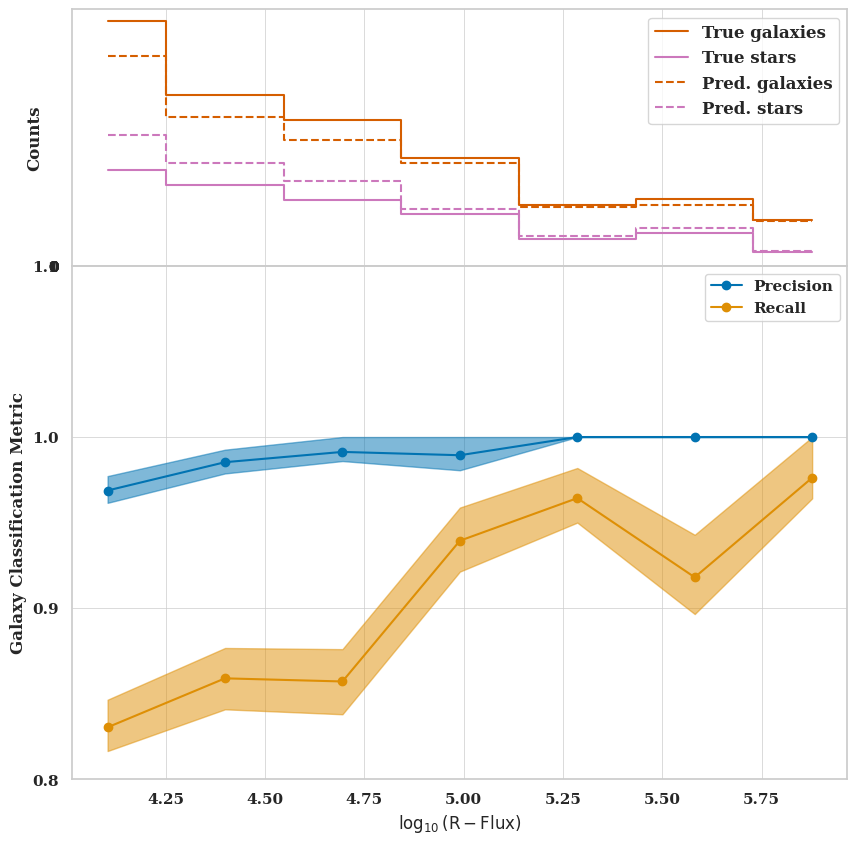

In [354]:
fig = create_figure(di)
plt.savefig('Ismael_Galaxy_Classification_rep.pdf', format='pdf')